In [14]:
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.applications import MobileNetV2
from transformers import BertTokenizer, TFBertForSequenceClassification
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Dense, Input, Dropout, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing import image
import pandas as pd
import torch
import time
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator


# Fix random seed for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

In [2]:
labeled_mapped_csv_path = Path.cwd() / "labeled_mapped.csv"

labels_to_ids = {
    "Educational": 0,
    "Entertainment": 1,
}

num_labels = len(labels_to_ids)

In [3]:
# Load data from CSV file
df = pd.read_csv(labeled_mapped_csv_path)

# Read header for column names
column_names = df.columns.tolist()
print("Column names:", column_names)
print("Dataframe shape:", df.shape)

# Print number of elements for each label
print()
print("Elements per label before making them equal:")
print(df['label'].value_counts())

# Only retain equal number of elements for each label
least_number_of_elements = df['label'].value_counts().min()
df = df.groupby('label').head(least_number_of_elements).reset_index(drop=True)

# Drop title
df = df.drop(['title'], axis=1)

# Print number of elements for each label
print()
print("Elements per label after making them equal:")
print(df['label'].value_counts())

Column names: ['label', 'title', 'path']
Dataframe shape: (2736, 3)

Elements per label before making them equal:
label
Entertainment    1825
Educational       911
Name: count, dtype: int64

Elements per label after making them equal:
label
Entertainment    911
Educational      911
Name: count, dtype: int64


In [4]:
print()
print("Dataframe shape:", df.shape)
print("Dataframe head:")
print(df.head())



Dataframe shape: (1822, 2)
Dataframe head:
           label   path
0  Entertainment  1.jpg
1  Entertainment  2.jpg
2  Entertainment  3.jpg
3  Entertainment  4.jpg
4    Educational  5.jpg


In [5]:
paths = df['path']
labels = df['label'] 

# Vectorize the labels
# labels = np.vectorize(labels_to_ids.get)(labels) # Vectorize the labels

# Split the data into train, validation, and test sets
paths_temp, paths_test, labels_temp, labels_test = train_test_split(paths, labels, test_size=0.2, random_state=42)

# Split the temporary set into separate training and validation sets
paths_train, paths_val, labels_train, labels_val = train_test_split(paths_temp, labels_temp, test_size=0.25, random_state=42)

print("Training set size: ", len(paths_train))
print("Validation set size: ", len(paths_val))
print("Test set size: ", len(paths_test))

Training set size:  1092
Validation set size:  365
Test set size:  365


In [6]:
datagen = ImageDataGenerator(rescale=1./255.)

train_generator = datagen.flow_from_dataframe(
    dataframe=pd.DataFrame({'filename': paths_train, 'class': labels_train}),
    directory='./mapped_unlabeled_data/',
    x_col='filename',
    y_col='class',
    target_size=(224, 224),
    batch_size=4,
    class_mode='categorical'
)

val_generator = datagen.flow_from_dataframe(
    dataframe=pd.DataFrame({'filename': paths_val, 'class': labels_val}),
    directory='./mapped_unlabeled_data/',
    x_col='filename',
    y_col='class',
    target_size=(224, 224),
    batch_size=4,
    class_mode='categorical'
)

test_generator = datagen.flow_from_dataframe(
    dataframe=pd.DataFrame({'filename': paths_test, 'class': labels_test}),
    directory='./mapped_unlabeled_data/',
    x_col='filename',
    y_col='class',
    target_size=(224, 224),
    batch_size=4,
    class_mode='categorical'
)

Found 1092 validated image filenames belonging to 2 classes.
Found 365 validated image filenames belonging to 2 classes.


Found 365 validated image filenames belonging to 2 classes.


In [27]:
print(test_generator.class_indices)

{'Educational': 0, 'Entertainment': 1}


In [15]:
# Load pre-trained MobileNet model + higher level layers
base_model = MobileNetV2(weights='imagenet', include_top=False, pooling='avg')

# Add higher level layers
x = base_model.output
predictions = Dense(2)(x)

# Create model
model = Model(inputs=base_model.input, outputs=predictions)

optimizer = tf.keras.optimizers.Adam(learning_rate=3e-5)
loss = tf.keras.losses.CategoricalCrossentropy(from_logits=True)

saved_model_path = "./MobileNetV2_fine_tuned"
print("Saving model to: ", saved_model_path)

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', 
    patience=3,
    verbose=1,
    mode='min',
    restore_best_weights=True,
)

model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])

history = model.fit(
    train_generator,
    epochs=100,
    batch_size=4,
    validation_data=val_generator,
    callbacks=[early_stopping],
)

# Save model
model.save(saved_model_path)
    

Saving model to:  ./MobileNetV2_fine_tuned
Epoch 1/100


2023-08-13 02:13:09.293406: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


273/273 [==============================] - ETA: 0s - loss: 0.5790 - accuracy: 0.7060

2023-08-13 02:13:29.783102: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


273/273 [==============================] - 24s 79ms/step - loss: 0.5790 - accuracy: 0.7060 - val_loss: 0.7762 - val_accuracy: 0.6356
Epoch 2/100
273/273 [==============================] - 20s 73ms/step - loss: 0.4665 - accuracy: 0.7885 - val_loss: 0.6078 - val_accuracy: 0.7068
Epoch 3/100
273/273 [==============================] - 20s 74ms/step - loss: 0.3802 - accuracy: 0.8205 - val_loss: 0.5020 - val_accuracy: 0.7699
Epoch 4/100
273/273 [==============================] - 20s 73ms/step - loss: 0.3460 - accuracy: 0.8489 - val_loss: 0.5554 - val_accuracy: 0.7452
Epoch 5/100
273/273 [==============================] - 20s 72ms/step - loss: 0.3010 - accuracy: 0.8800 - val_loss: 0.5132 - val_accuracy: 0.7699
Epoch 6/100
273/273 [==============================] - 20s 74ms/step - loss: 0.2726 - accuracy: 0.8919 - val_loss: 0.4440 - val_accuracy: 0.8000
Epoch 7/100
273/273 [==============================] - 20s 74ms/step - loss: 0.2502 - accuracy: 0.8938 - val_loss: 0.4686 - val_accuracy: 0.82

INFO:tensorflow:Assets written to: ./MobileNetV2_fine_tuned/assets


In [18]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, None, None, 3)]      0         []                            
                                                                                                  
 Conv1 (Conv2D)              (None, None, None, 32)       864       ['input_2[0][0]']             
                                                                                                  
 bn_Conv1 (BatchNormalizati  (None, None, None, 32)       128       ['Conv1[0][0]']               
 on)                                                                                              
                                                                                                  
 Conv1_relu (ReLU)           (None, None, None, 32)       0         ['bn_Conv1[0][0]']      

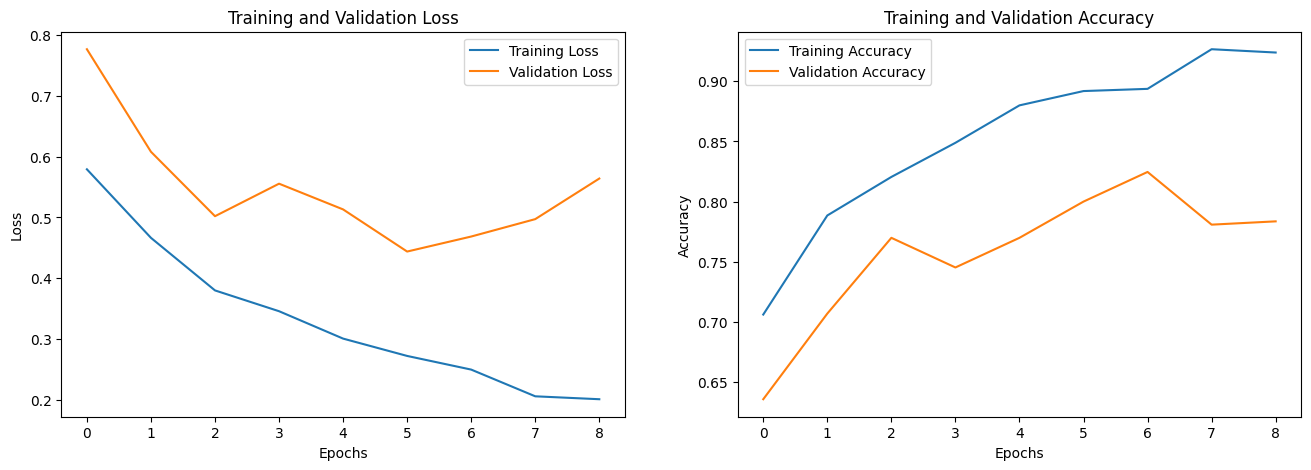

In [20]:
# Visualize the training process
history = model.history

figure, axis = plt.subplots(1, 2, figsize=(16, 5))
axis[0].plot(history.history['loss'], label='Training Loss')
axis[0].plot(history.history['val_loss'], label='Validation Loss')
axis[0].set_title('Training and Validation Loss')
axis[0].set_xlabel('Epochs')
axis[0].set_ylabel('Loss')
axis[0].legend()

axis[1].plot(history.history['accuracy'], label='Training Accuracy')
axis[1].plot(history.history['val_accuracy'], label='Validation Accuracy')
axis[1].set_title('Training and Validation Accuracy')
axis[1].set_xlabel('Epochs')
axis[1].set_ylabel('Accuracy')
axis[1].legend()

plt.show()

In [22]:
# Test the model
print('Evaluate on test data')
model = tf.keras.models.load_model('./MobileNetV2_fine_tuned')
results = model.evaluate(test_generator, batch_size=4)

Evaluate on test data


2023-08-13 02:17:02.560405: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


92/92 [==============================] - 3s 24ms/step - loss: 0.5150 - accuracy: 0.8164


2023-08-13 02:25:38.456190: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 1s 672ms/step
Time taken:  0.6941499710083008 seconds
Predicted class:  Educational


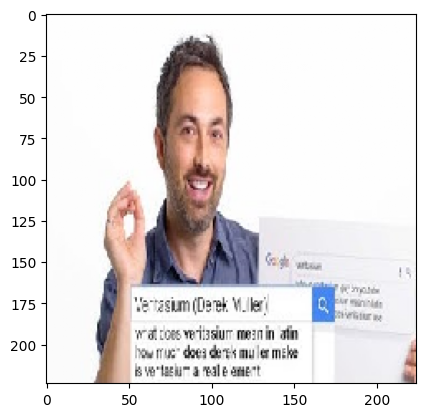

In [35]:
# Calculate the time taken to predict one image
model = tf.keras.models.load_model('./MobileNetV2_fine_tuned')

start = time.time()
img = image.load_img('extra_unlabeled_test_images/B.jpg', target_size=(224, 224))
img = image.img_to_array(img)
img = img / 255.0
img = np.expand_dims(img, axis=0)
predection = model.predict(img)
print("Time taken: ", time.time() - start, "seconds")
plt.imshow(img[0])
print("Predicted class: ", ["Educational", "Entertainment"][predection.argmax()])
